Importing the Essential Libraries and loading data :

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler,  ClusterCentroids
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score
from sklearn.metrics import f1_score
from sklearn.svm import SVC

In [2]:
df = pd.read_csv('churn_bank.csv')
df.head()


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Now, we check the data set information :

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


Check the missing and duplicates values :

In [4]:
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [5]:
df.duplicated().sum() 

0

These columns are not interesting for the following so we delete them

In [8]:
df.drop(['CustomerId', 'Surname', 'Geography'], axis =1, inplace = True)

Exploratory Data Analysis :

Categorical Variables

In [16]:
df_cat = df[col for col in df.columns if df[col].dtypes == "O" or (df[col].nunique() < 10 and df[col].dtypes != "O")]
df_cat

['Gender', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited']

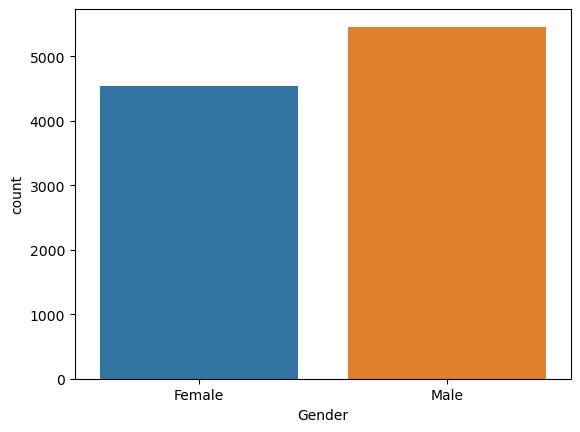

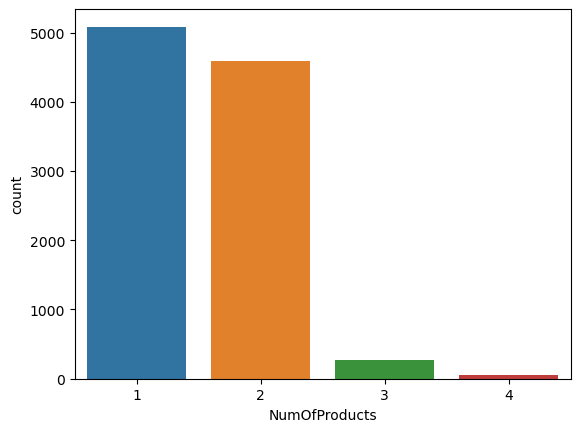

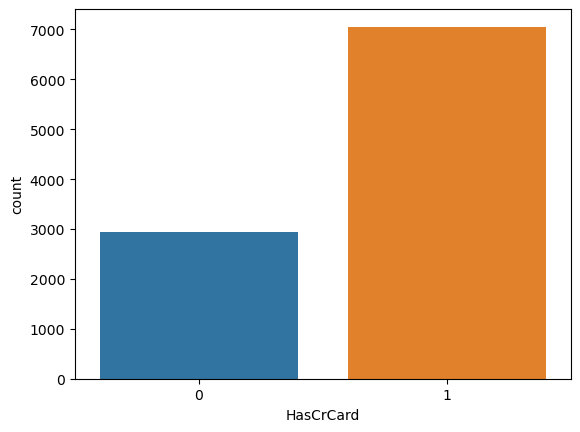

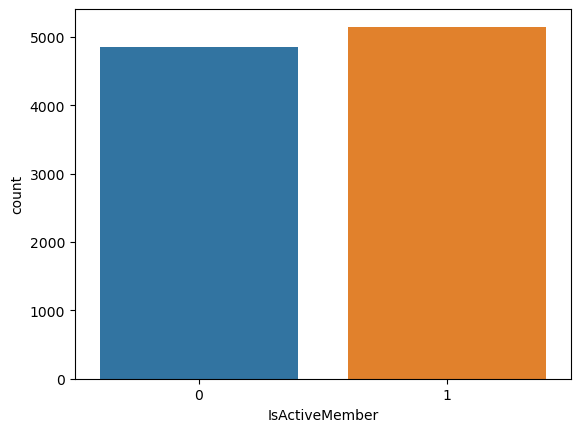

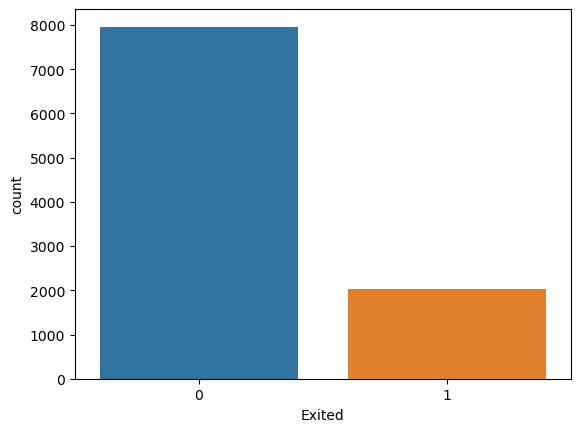

In [17]:
for col in df_cat:
    sns.countplot(x = col, data = df);
    plt.show()

We notice that for our target variable, class 1 is in the minority

In [18]:
df['Exited'].value_counts(normalize = True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

In our customer base, 20.37% of existing customers have left the bank, which means that a naive model that predicts that all customers stay, would already score 79.63% accuracy.

From the graphs we can make several observations: 
- We have more men than women 
- Very few customers have 3 or 4 products
- The majority of customers have a credit card
- There is approximately the same proportion of active and non-active customers

Quantitative variables

In [20]:
df_num = [col for col in df.columns if df[col].dtypes != "O" and col not in df_cat]
df_num

['RowNumber', 'CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']

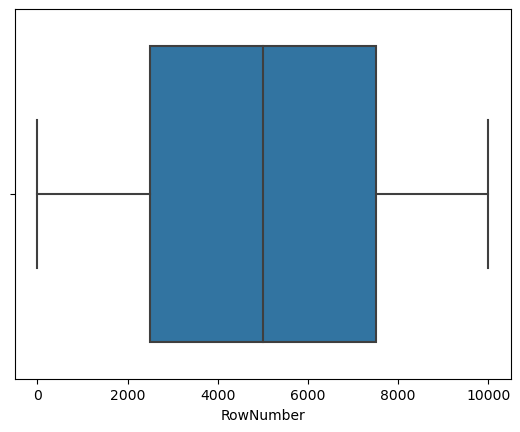

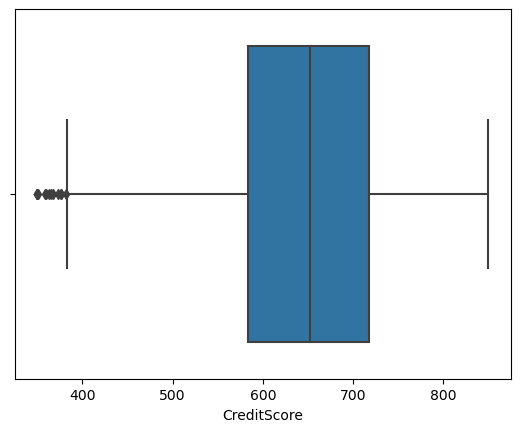

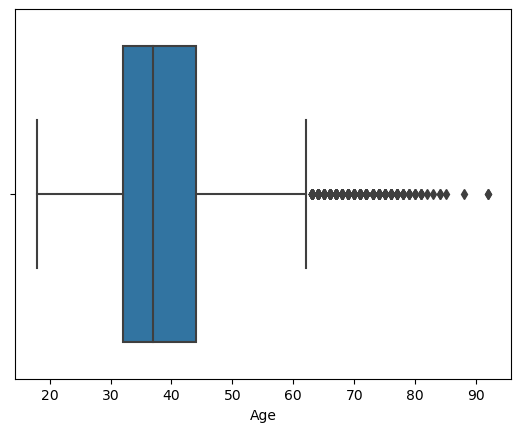

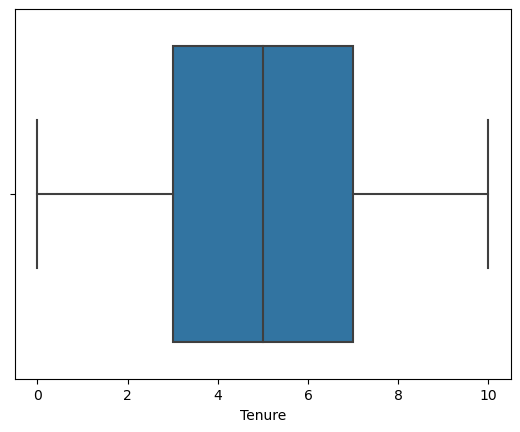

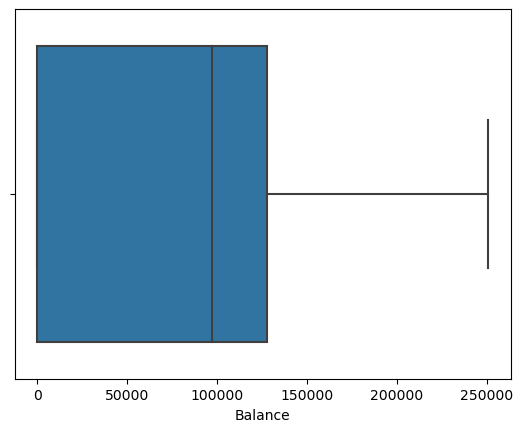

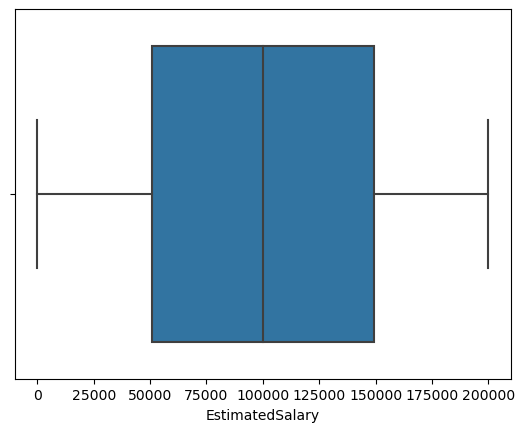

In [22]:
for col in df_num:
    sns.boxplot(x=df[col]);
    plt.show()

Visualizing the correlations between numerical variables : The variables have very little correlation with each other

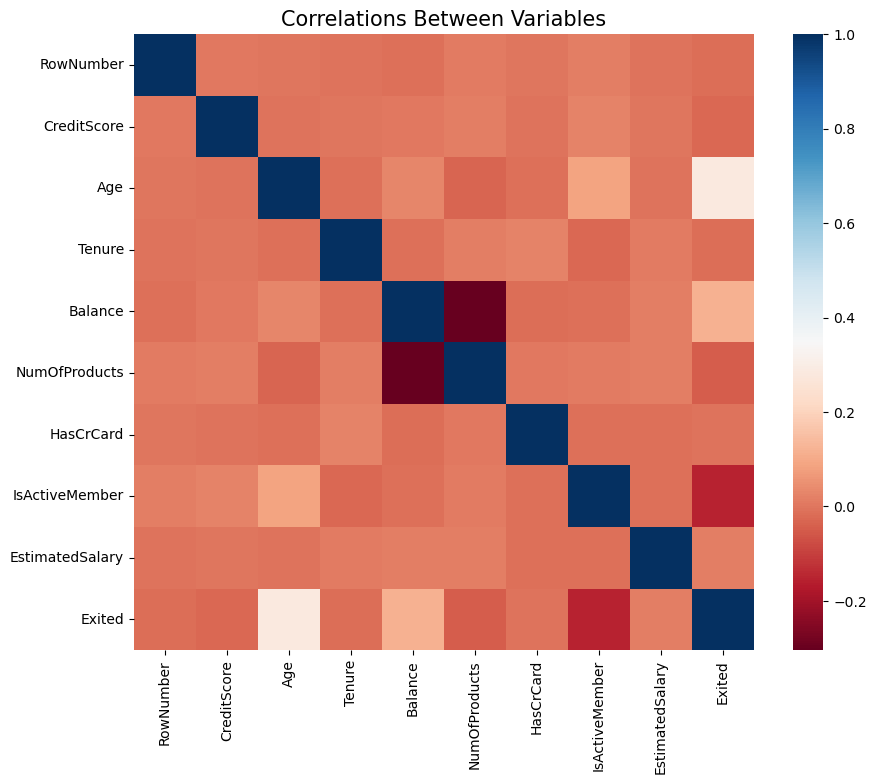

In [26]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), cmap="RdBu")
plt.title("Correlations Between Variables", size=15)
plt.show()

Churner by gender :

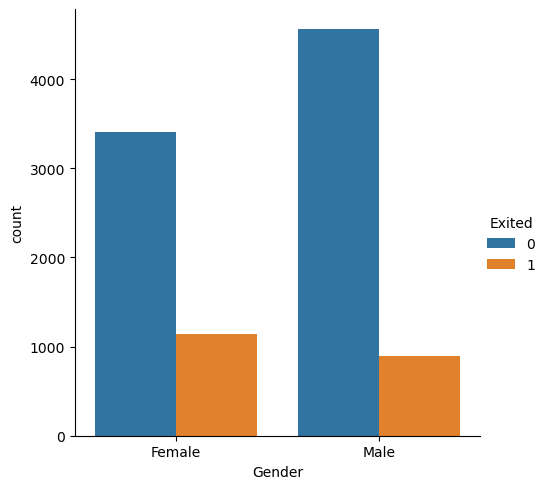

In [29]:
sns.catplot(x="Gender", kind="count", hue="Exited", data=df)

Preparing data for prediction :

Transformation of the variable NumOfProducts to type 'object'.
and encoding of the modalities of the variable Gender ('Male', 'Female') by 0 and 1.

In [30]:
df['NumOfProducts'] = df['NumOfProducts'].astype('object')

le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])

Separation of the data into a DataFrame feats containing the explanatory variables and target containing the variable Exited.

In [31]:
feats = df.drop(['Exited'], axis =1)
target = df['Exited']

Transforming the variable NumOfProducts into several indicator variables :

In [33]:
feats = pd.get_dummies(feats, prefix=['products'], prefix_sep='_')

c:\Users\beaux\anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [35]:
feats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CreditScore      10000 non-null  int64  
 2   Gender           10000 non-null  int32  
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   HasCrCard        10000 non-null  int64  
 7   IsActiveMember   10000 non-null  int64  
 8   EstimatedSalary  10000 non-null  float64
 9   products_1       10000 non-null  uint8  
 10  products_2       10000 non-null  uint8  
 11  products_3       10000 non-null  uint8  
 12  products_4       10000 non-null  uint8  
dtypes: float64(2), int32(1), int64(6), uint8(4)
memory usage: 703.2 KB


In [36]:
X_train, X_test, y_train, y_test = train_test_split(feats, target, test_size=0.25)

Standardisation of continuous variables :

In [37]:
cols = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

sc = StandardScaler()
X_train[cols] = sc.fit_transform(X_train[cols])
X_test[cols] = sc.transform(X_test[cols])

X_train

,RowNumber,CreditScore,Gender,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,products_1,products_2,products_3,products_4
2534,2535,0.690204,0,-0.371219,5,0.413065,1,0,1.250602,1,0,0,0
9486,9487,1.061656,1,-0.655528,6,1.606596,1,1,1.067902,1,0,0,0
5322,5323,0.731477,0,0.102629,7,-1.240172,1,1,0.390205,0,1,0,0
4841,4842,-0.651147,0,0.481708,5,0.771367,1,1,-1.010386,0,1,0,0
4239,4240,-0.145561,0,0.007860,3,0.655272,1,0,1.467801,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,195,-0.723374,1,-0.939837,9,-0.251728,1,0,0.485580,0,1,0,0
516,517,-1.879000,0,1.618943,10,-1.240172,0,1,-0.656377,0,0,1,0
3363,3364,0.999747,1,-0.086910,2,0.837750,1,0,-0.187375,1,0,0,0
7425,7426,-1.012280,1,-0.560758,3,1.081762,1,0,-0.715574,1,0,0,0


First model : SVM

In [41]:
svm = SVC(gamma ='scale')
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
precision = svm.score(X_test, y_test)
print(precision*100)

80.80000000000001


Second model : OverSampling

In [44]:
rOs = RandomOverSampler()
X_ro, y_ro = rOs.fit_resample(X_train, y_train)
print('Classes échantillon oversampled :', dict(pd.Series(y_ro).value_counts()))

#SMOTE
smo = SMOTE()
X_sm, y_sm = smo.fit_resample(X_train, y_train)
print('Classes échantillon SMOTE :', dict(pd.Series(y_sm).value_counts()))

Classes échantillon oversampled : {0: 5943, 1: 5943}
Classes échantillon SMOTE : {0: 5943, 1: 5943}


In [45]:
svm = SVC(gamma ='scale')
svm.fit(X_ro, y_ro)
y_pred = svm.predict(X_test)
precision = svm.score(X_test, y_test)
print(precision*100)
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
print(classification_report_imbalanced(y_test, y_pred))

54.04
                   pre       rec       spe        f1       geo       iba       sup

          0       0.81      0.56      0.44      0.66      0.50      0.25      2020
          1       0.19      0.44      0.56      0.27      0.50      0.25       480

avg / total       0.69      0.54      0.47      0.59      0.50      0.25      2500

